# 1. Genetic Algorithm
---

In [1]:
import numpy as np
import pandas 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, matthews_corrcoef, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from bisect import bisect_left
from tqdm import notebook
import math
import random 
import matplotlib.pyplot as plt
np.seterr(all="ignore")

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
def initilialize_poplulation(numberOfPopulation,objectData): # OK
    criterion = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    splitter = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    maxDepth = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    minSamplesSplit = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    minSamplesLeaf = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    minWeightFractionLeaf = np.empty([numberOfPopulation, 1])
    ccpAlpha = np.empty([numberOfPopulation, 1])
    normalization = np.empty([numberOfPopulation, 1], dtype=np.uint8)
    classWeight = np.empty([numberOfPopulation, 1])
    featureSelection = np.empty([numberOfPopulation, objectData.shape[1]], dtype=np.uint8)
    
    print("<Initilialize Poplulation>",end='')
    for i in notebook.tqdm(range(numberOfPopulation)):
        # print(i)
        criterion[i] = int(random.randrange(0, 2, step=1))
        splitter[i] = int(random.randrange(0, 2, step=1))
        maxDepth[i] = int(random.randrange(2, 41, step=1))
        minSamplesSplit[i] = int(random.randrange(2, 101, step=1))
        minSamplesLeaf[i] = int(random.randrange(1, 201, step=1))
        minWeightFractionLeaf[i] = round(random.uniform(0.001, 0.1), 3)
        ccpAlpha[i] = round(random.uniform(0.00001, 0.004), 5)
        normalization[i] = int(random.randrange(0, 6, step=1))
        classWeight[i] = round(random.uniform(0.01, 1), 2)
        for j in range(objectData.shape[1]):
            featureSelection[i][j] = int(random.randrange(0, 2, step=1))
#             print("<feature weight %s = %s>"%(j,feature_weight[i][j]))
#         print("<최초 %s번째 유전자 생성> Criterion: %s | Max Depth: %s | min samples split: %s | max leaf nodes: %s | randomstate: %s | true-false weight: %s/%s"%(i+1,criterion[i],maxDepth[i],minSamplesSplit[i],maxLeafNodes[i],randomState[i],trueWeight[i],falseWeight[i]))
    population = np.concatenate(
        (criterion, splitter,maxDepth, minSamplesSplit, minSamplesLeaf, minWeightFractionLeaf, ccpAlpha, normalization,classWeight,featureSelection), axis=1)
#     print("Population")
#     print(pandas.DataFrame(population))
    return population

In [3]:
def score(y_true,y_pred): #OK
    arr = confusion_matrix(y_true,y_pred)
    pd = arr[1][1]/(arr[1][1]+arr[1][0])
    pf = arr[0][1]/(arr[0][0]+arr[0][1])
    fallout = 1-pf
    g_measure = 2*((pd*fallout)/(pd+fallout))
    fi = (arr[0][1]+arr[1][1])/(arr[0][0]+arr[0][1]+arr[1][1]+arr[1][0])
    FIR = (pd-fi)/pd
    return pd,pf,g_measure,FIR

In [4]:
def fitness_Gmeasure(y_true, y_pred): #OK
        pd,pf,g_measure,FIR = score(y_true, y_pred)
        fitness = round(g_measure, 4)
        return fitness

In [5]:
def criterion_convert(param): #OK
        if param==0:
            cr = 'gini'
        else:
            cr = 'entropy'
        return cr
    
def splitter_convert(param): #OK
        if param==0:
            sc = 'best'
        else:
            sc = 'random'
        return sc

In [6]:
def Norm(X_train,X_test,norm):
    if norm==0: # None
        return X_train,X_test
    elif norm==1:#MinMax (all)
        scaler=MinMaxScaler()
        scaler.fit(np.concatenate((X_train, X_test), axis=0))
        X_train_norm=scaler.transform(X_train)
        X_test_norm=scaler.transform(X_test)
        return X_train_norm, X_test_norm
    elif norm==2:#z-score (all)
        scaler=StandardScaler()
        scaler.fit(np.concatenate((X_train, X_test), axis=0))
        X_train_norm=scaler.transform(X_train)
        X_test_norm=scaler.transform(X_test)
        return X_train_norm, X_test_norm
    elif norm==3:#z-score (source distribution)
        scaler=StandardScaler()
        scaler.fit(X_train)
        X_train_norm=scaler.transform(X_train)
        X_test_norm=scaler.transform(X_test)
        return X_train_norm, X_test_norm
    elif norm==4: #z-score (target distribution)
        scaler=StandardScaler()
        scaler.fit(X_test)
        X_train_norm=scaler.transform(X_train)
        X_test_norm=scaler.transform(X_test)
        return X_train_norm, X_test_norm
    elif norm==5: #logarithmic filtering
        X_train_norm=np.log10(np.where(X_train<0.001,0.001,X_train))
        X_test_norm=np.log10(np.where(X_test<0.001,0.001,X_test))
        return X_train_norm, X_test_norm

In [7]:
def feature_selection(X_train,X_test,vector):
    index=[]
    col_index=0
    assert len(vector)!=62
    for i in vector:
        if i==1:
            index.append(col_index)
        col_index+=1
    if not index:
        index.append(0)
    X_train=X_train[:,index]
    X_test=X_test[:,index]
    return X_train, X_test

In [8]:
def train_population(population, X_train,y_train,X_test,y_test):
    g_measure = []
    clf_hist=[]
    for i in range(population.shape[0]):
        param = { 'Criterion': population[i][0],
                  'Splitter': population[i][1],
                  'Max_Depth':population[i][2],
                  'Min_Samples_Split':population[i][3],
                  'Min_Samples_Leaf':population[i][4],
                  'Min_Weight_Fraction_Leaf':population[i][5],
                  'CCP_Alpha':population[i][6],
                  'Normalization':population[i][7],
                  'Class_Weight':population[i][8],
                  'Feature_selection':population[i][9:]}

        balance = {True:1,False:param['Class_Weight'] }
        clf = DecisionTreeClassifier(criterion=criterion_convert(param['Criterion']),
                                     splitter=splitter_convert(param['Splitter']),
                                     max_depth=int(param['Max_Depth']),
                                     min_samples_split=int(param['Min_Samples_Split']),
                                     min_samples_leaf=int(param['Min_Samples_Leaf']),
                                     min_weight_fraction_leaf=param['Min_Weight_Fraction_Leaf'],
                                     ccp_alpha=param['CCP_Alpha'],
                                     class_weight=balance)

        #Feature Selection                                                         
        X_tr,X_vali=feature_selection(X_train,X_test,param['Feature_selection'].astype(np.int64))

        #Normalization
        X_tr,X_vali=Norm(X_tr,X_vali,param['Normalization'])

        clf.fit(X_tr, y_train)
        preds = clf.predict(X_vali)
        g_measure.append(fitness_Gmeasure(y_test, preds))
        clf_hist.append(clf)
    return g_measure,clf_hist

In [9]:
def new_parents_selection(population, fitness, numParents): #OK
    selectedParents = np.empty((numParents, population.shape[1]))  # create an array to store fittest parents
    fitness_v=fitness
    # find the top best performing parents
    for parentId in range(numParents):
        bestFitnessId = np.where(fitness_v == np.max(fitness_v))[0][0]
        selectedParents[parentId, :] = population[bestFitnessId, :]
        fitness_v[bestFitnessId] = -1  # set this value to negative, in case of F1-score, so this parent is not selected again
    return selectedParents

In [10]:
def crossover_uniform(parents, childrenSize):
    crossoverPointIndex = np.arange(0, np.uint8(childrenSize[1]), 1, dtype=np.uint8)  # get all the index
    crossoverPointIndex1 = np.random.randint(0, np.uint8(childrenSize[1]),
                                             np.uint8(childrenSize[1] / 2))  # select half  of the indexes randomly
    crossoverPointIndex2 = np.array(
        list(set(crossoverPointIndex) - set(crossoverPointIndex1)))  # select leftover indexes

    children = np.empty(childrenSize)


    for i in range(childrenSize[0]):
        # find parent 1 index
        parent1_index = int(i % parents.shape[0])
        # find parent 2 index
        parent2_index = int((i + 1) % parents.shape[0])
        # insert parameters based on random selected indexes in parent 1
        children[i, crossoverPointIndex1] = parents[parent1_index, crossoverPointIndex1]
        # insert parameters based on random selected indexes in parent 1
#         print(crossoverPointIndex2,parent2_index)
        children[i, crossoverPointIndex2] = parents[parent2_index, crossoverPointIndex2]
    return children

In [11]:
def mutation(crossover, numberOfParameters,mutation_rate):
    # Define minimum and maximum values allowed for each parameter
    minMaxValue = np.zeros((numberOfParameters, 2))
    minMaxValue[0, :] = [0, 1]  
    minMaxValue[1, :] = [0, 1]  
    minMaxValue[2, :] = [2, 40]  
    minMaxValue[3, :] = [2, 100]  
    minMaxValue[4, :] = [1, 200]  
    minMaxValue[5, :] = [0.001, 0.1]  
    minMaxValue[6, :] = [0.00001, 0.004]  
    minMaxValue[7, :] = [0, 5]  
    minMaxValue[8, :] = [0.01, 1] 
    minMaxValue[9:, :] = [0, 1]  
    
    # Mutation changes a single gene in each offspring randomly.
    mutationValue = 0

    # indtroduce mutation by changing one parameter, and set to max or min if it goes out of range
    for idx in range(crossover.shape[0]):
        mutationidx = round(random.uniform(0.001, 1), 3)
        if mutation_rate < mutationidx:
            continue
        for parameterSelect in range(crossover.shape[1]):            
            # parameterSelect = np.random.randint(0, 7, 1)
            # print(parameterSelect)
            if parameterSelect == 0:  
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            if parameterSelect == 1:  
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            if parameterSelect == 2:  
                mutationValue = np.random.randint(-20, 21, 1)
            if parameterSelect == 3:  
                mutationValue = np.random.randint(-50, 51, 1)
            if parameterSelect == 4:  
                mutationValue = np.random.randint(-100, 101, 1)
            if parameterSelect == 5:  
                mutationValue = round(np.random.uniform(-0.05, 0.05), 3)
            if parameterSelect == 6:  
                mutationValue = round(np.random.uniform(-0.002, 0.002), 5)
            if parameterSelect == 7:  
                mutationValue = np.random.randint(-2, 3, 1)
            if parameterSelect == 8:
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            else :  
                mutationValue = round(np.random.uniform(-0.5, 0.5), 2)
            
            if parameterSelect!=5 and parameterSelect!=6 and parameterSelect!=8:
                new_value= int(crossover[idx, parameterSelect] + mutationValue)
            else:
                new_value=crossover[idx, parameterSelect] + mutationValue
            crossover[idx, parameterSelect] = new_value            
            if (crossover[idx, parameterSelect] > minMaxValue[parameterSelect, 1]):
                crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 1]
            if (crossover[idx, parameterSelect] < minMaxValue[parameterSelect, 0]):
                crossover[idx, parameterSelect] = minMaxValue[parameterSelect, 0]
    return crossover

In [12]:
def generation(X_train, y_train,X_test,y_test, mutation_rate):
    #initailization    
    mutationRate = mutation_rate
    numberOfHyperParameters = 9
    numberOfParameters = numberOfHyperParameters+X_train.shape[1]
    numberOfPopulation = 100
    numberOfParents = 20
    numberOfGenerations = 1000
    

    # define the population size
    populationSize = (numberOfPopulation, numberOfParameters)
    # initialize the population with randomly generated parameters
    population = initilialize_poplulation(numberOfPopulation,X_train)
#     print(population.shape)
    # define an array to store the fitness  hitory
    fitnessHistory = np.empty([numberOfGenerations + 1, numberOfPopulation])
    # define an array to store the value of each parameter for each parent and generation
    populationHistory = np.empty([(numberOfGenerations + 1) * numberOfPopulation, numberOfParameters])
    # insert the value of initial parameters in history

    populationHistory[0:numberOfPopulation, :] = population
    iteration_g=[]
    
    print("<Evolution>")
    for generation in notebook.tqdm(range(numberOfGenerations)):
        #print(" (%s / %s) 세대 개체 생성" % (generation+1,numberOfGenerations))
        fitnessValue,clf = train_population(population=population,
                                            X_train=X_train,
                                            y_train=y_train,
                                            X_test=X_test,
                                            y_test=y_test)

        fitnessHistory[generation, :] = fitnessValue
        # print('Max G-measure in the this iteration = {}'.format(np.max(fitnessHistory[generation, :])))
        iteration_g.append((np.max(fitnessHistory[generation, :])))

        parents = new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfParents)
#         print("-------parents-------")
#         print(parents)
        # prophets = geneticDicisionTree.new_parents_selection(population=population, fitness=fitnessValue, numParents=numberOfProphets)

        children = crossover_uniform(parents=parents, childrenSize=((populationSize[0] - parents.shape[0]), numberOfParameters))

        children_mutated = mutation(children, numberOfParameters, mutationRate)
        
        population[0:parents.shape[0], :] = parents #fittest parents
        population[parents.shape[0]:, :] = children_mutated #children
#         print("-------population-------")
#         print(population)
        populationHistory[(generation + 1) * numberOfPopulation: (generation + 1) * numberOfPopulation + numberOfPopulation, :] = population

    # Best solution from the final iteration
    x=range(1,numberOfGenerations+1)
    plt.plot(x,iteration_g)
    plt.xlabel('Iteration')
    plt.ylabel('G-measure')
    
    # plt.set_title('Train Set Distribu')
    plt.ylim(0.5, 0.95)
    plt.show()

    fitness,clf = train_population(population=population, X_train=X_train, y_train=y_train,X_test=X_test,y_test=y_test)
    fitnessHistory[generation + 1, :] = fitness
    # index of the best solution
    bestFitnessIndex = np.where(fitness == np.max(fitness))[0][0]
    best_clf=clf[bestFitnessIndex]
    best_gene = np.empty([numberOfParameters,1])
    for i in range(numberOfParameters):
        best_gene[i]=population[bestFitnessIndex][i]
    
#     print("----------------------------------------")
#     print("Best parameters are:")
#     if population[bestFitnessIndex][0]==0:
#         c_r='gini'
#     else:
#         c_r='entropy'
#     print('criterion', c_r)
#     print('max_depth', population[bestFitnessIndex][1])
#     print('min_samples_split', int(population[bestFitnessIndex][2]))
#     print('max_leaf_nodes', population[bestFitnessIndex][3])
#     print('random_state', population[bestFitnessIndex][4])
#     print('class_weight', population[bestFitnessIndex][5], population[bestFitnessIndex][6])
#     print("----------------------------------------")
    return fitness[bestFitnessIndex],best_gene,best_clf

In [13]:
def weighted_GA_DT(X_train,X_test,y_train,y_test):
    fitness, best_gene,best_clf = generation(X_train=X_train,
                                             y_train=y_train,
                                             X_test=X_test,
                                             y_test=y_test,
                                             mutation_rate=0.01)
    X_train,X_test=feature_selection(X_train,
                                     X_test,
                                     best_gene[9:])
    X_train,X_test=Norm(X_train,X_test,best_gene[7])
    best_clf.fit(X_train,y_train)
    preds = best_clf.predict(X_test)    
    return preds

# 2.Model Evaluation
---

In [14]:
df = pandas.read_csv('../../Dataset/AEEEM/EQ.csv')

In [15]:
X = np.array(df.loc[:,'ck_oo_numberOfPrivateMethods':'LDHH_numberOfMethods'])
y = np.array(df['class'])

In [16]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=False)

In [17]:
pd_score=[]
pf_score=[]
g_measure_score = []
fir_score=[]
best_fitness=[]
accuracy=[]
best_gene= np.empty([7, 1])
conf_matrix_list_of_arrays = []
class_report_list_of_arrays = []
roc_auc_score_list_of_arrays = []
mcc_list_of_arrays = []
cm = None
y_predicted_overall = None
y_test_overall = None  
i=0

<Initilialize Poplulation>


<Evolution>


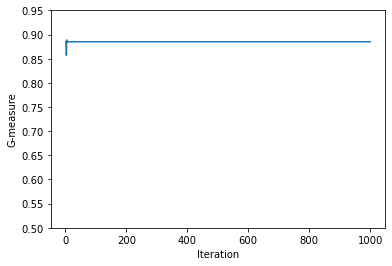

--------------------------------------0 : Result--------------------------------------
PD: 0.9230769230769231
PF: 0.15
G measure: 0.8850325379609545
FIR: 0.5075757575757576
              precision    recall  f1-score   support

       False      0.944     0.850     0.895        20
        True      0.800     0.923     0.857        13

    accuracy                          0.879        33
   macro avg      0.872     0.887     0.876        33
weighted avg      0.888     0.879     0.880        33

[[17  3]
 [ 1 12]]
<Initilialize Poplulation>


<Evolution>


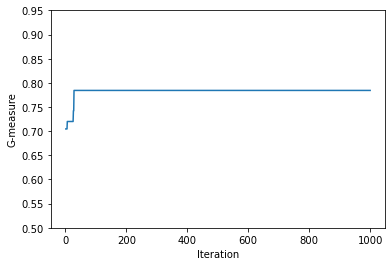

--------------------------------------1 : Result--------------------------------------
PD: 0.7692307692307693
PF: 0.2
G measure: 0.7843137254901961
FIR: 0.4484848484848485
              precision    recall  f1-score   support

       False      0.842     0.800     0.821        20
        True      0.714     0.769     0.741        13

    accuracy                          0.788        33
   macro avg      0.778     0.785     0.781        33
weighted avg      0.792     0.788     0.789        33

[[16  4]
 [ 3 10]]
<Initilialize Poplulation>


<Evolution>


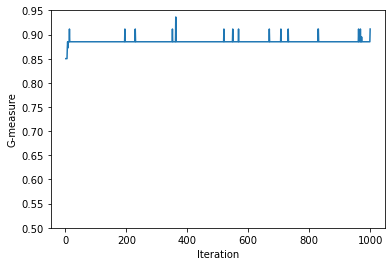

--------------------------------------2 : Result--------------------------------------
PD: 0.6923076923076923
PF: 0.3
G measure: 0.6961325966850829
FIR: 0.3434343434343434
              precision    recall  f1-score   support

       False      0.778     0.700     0.737        20
        True      0.600     0.692     0.643        13

    accuracy                          0.697        33
   macro avg      0.689     0.696     0.690        33
weighted avg      0.708     0.697     0.700        33

[[14  6]
 [ 4  9]]
<Initilialize Poplulation>


<Evolution>


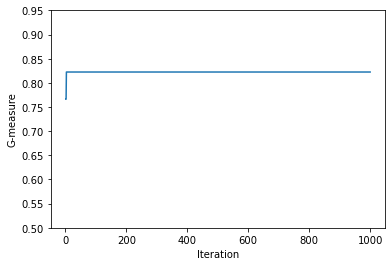

--------------------------------------3 : Result--------------------------------------
PD: 0.8461538461538461
PF: 0.2
G measure: 0.8224299065420562
FIR: 0.4628099173553719
              precision    recall  f1-score   support

       False      0.889     0.800     0.842        20
        True      0.733     0.846     0.786        13

    accuracy                          0.818        33
   macro avg      0.811     0.823     0.814        33
weighted avg      0.828     0.818     0.820        33

[[16  4]
 [ 2 11]]
<Initilialize Poplulation>


<Evolution>


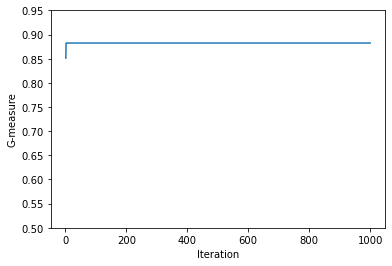

--------------------------------------4 : Result--------------------------------------
PD: 1.0
PF: 0.21052631578947367
G measure: 0.8823529411764706
FIR: 0.46875
              precision    recall  f1-score   support

       False      1.000     0.789     0.882        19
        True      0.765     1.000     0.867        13

    accuracy                          0.875        32
   macro avg      0.882     0.895     0.875        32
weighted avg      0.904     0.875     0.876        32

[[15  4]
 [ 0 13]]
<Initilialize Poplulation>


<Evolution>


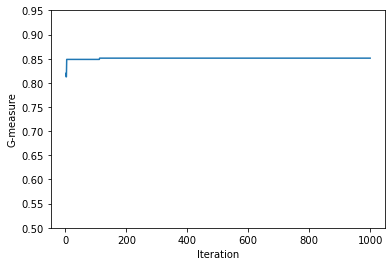

--------------------------------------5 : Result--------------------------------------
PD: 0.9230769230769231
PF: 0.21052631578947367
G measure: 0.8510638297872342
FIR: 0.45833333333333337
              precision    recall  f1-score   support

       False      0.938     0.789     0.857        19
        True      0.750     0.923     0.828        13

    accuracy                          0.844        32
   macro avg      0.844     0.856     0.842        32
weighted avg      0.861     0.844     0.845        32

[[15  4]
 [ 1 12]]
<Initilialize Poplulation>


<Evolution>


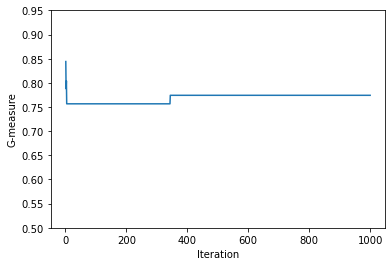

--------------------------------------6 : Result--------------------------------------
PD: 1.0
PF: 0.3684210526315789
G measure: 0.7741935483870968
FIR: 0.375
              precision    recall  f1-score   support

       False      1.000     0.632     0.774        19
        True      0.650     1.000     0.788        13

    accuracy                          0.781        32
   macro avg      0.825     0.816     0.781        32
weighted avg      0.858     0.781     0.780        32

[[12  7]
 [ 0 13]]
<Initilialize Poplulation>


<Evolution>


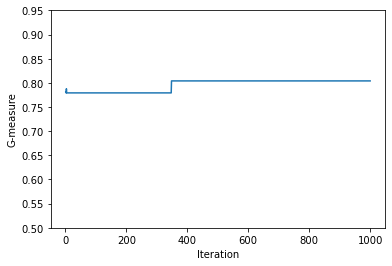

--------------------------------------7 : Result--------------------------------------
PD: 0.7692307692307693
PF: 0.15789473684210525
G measure: 0.8040201005025126
FIR: 0.47187500000000004
              precision    recall  f1-score   support

       False      0.842     0.842     0.842        19
        True      0.769     0.769     0.769        13

    accuracy                          0.812        32
   macro avg      0.806     0.806     0.806        32
weighted avg      0.812     0.812     0.812        32

[[16  3]
 [ 3 10]]
<Initilialize Poplulation>


<Evolution>


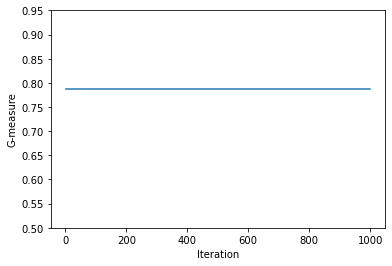

--------------------------------------8 : Result--------------------------------------
PD: 0.8461538461538461
PF: 0.2631578947368421
G measure: 0.7877237851662403
FIR: 0.40909090909090906
              precision    recall  f1-score   support

       False      0.875     0.737     0.800        19
        True      0.688     0.846     0.759        13

    accuracy                          0.781        32
   macro avg      0.781     0.791     0.779        32
weighted avg      0.799     0.781     0.783        32

[[14  5]
 [ 2 11]]
<Initilialize Poplulation>


<Evolution>


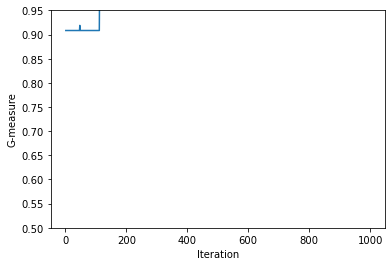

--------------------------------------9 : Result--------------------------------------
PD: 1.0
PF: 0.0
G measure: 1.0
FIR: 0.625
              precision    recall  f1-score   support

       False      1.000     1.000     1.000        20
        True      1.000     1.000     1.000        12

    accuracy                          1.000        32
   macro avg      1.000     1.000     1.000        32
weighted avg      1.000     1.000     1.000        32

[[20  0]
 [ 0 12]]

--------------------------------------average--------------------------------------
PD : 0.876923076923077
PF : 0.20605263157894735
G_measure : 0.8287262971697844
FIR : 0.4570354109274565


In [18]:
for train_index, test_index in notebook.tqdm(kf.split(X,y)): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pred= weighted_GA_DT(X_train=X_train,
                          X_test=X_test,
                          y_train=y_train,
                          y_test=y_test)
    
    pd,pf,g_measure,FIR = score(y_test, pred)  
    
    pd_score.append(pd)
    pf_score.append(pf)
    g_measure_score.append(g_measure)
    fir_score.append(FIR)
    
    print('--------------------------------------{} : Result--------------------------------------'.format(i))
    print('PD: {}\nPF: {}\nG measure: {}\nFIR: {}'.format(pd,pf,g_measure,FIR))
    i=i+1
    
    conf_matrix = confusion_matrix(y_test, pred)
    conf_matrix_list_of_arrays.append(conf_matrix)
    roc_auc = roc_auc_score(y_test, pred)
    roc_auc_score_list_of_arrays.append(roc_auc)
    mcc = matthews_corrcoef(y_test, pred)
    mcc_list_of_arrays.append(mcc)
    cv_cm = confusion_matrix(y_test, pred)
    # sum the cv per fold
    print(classification_report(y_test, pred, digits=3))
    print(cv_cm)

print('--------------------------------------average--------------------------------------')
print("PD : {}".format(sum(pd_score)/len(pd_score)))
print("PF : {}".format(sum(pf_score)/len(pf_score)))
print("G_measure : {}".format(sum(g_measure_score)/len(g_measure_score)))
print("FIR : {}".format(sum(fir_score)/len(fir_score)))